# 0. Set Up

In [1]:
# Librerias
!git clone https://github.com/domingomery/balu3
!pip install ./balu3

# Numpy & Maplotlib
import numpy             as np
import matplotlib.pyplot as plt
import cv2


# Balu
from   balu3.ft.norm     import minmax
from   balu3.fx.chr      import lbp, haralick, gabor, hog, basicint, contrast, clp
from   balu3.fs.sel      import jfisher
from   balu3.fs.sel      import sfs, exsearch, clean
from   balu3.fx.geo      import basicgeo,fitellipse,hugeo,flusser,gupta
from   tqdm.auto         import tqdm
from   balu3.im.proc import im_grad,fspecial,gradlog
from   balu3.ft.trans  import pca

# Sklearn
from   sklearn.metrics   import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from   sklearn.neighbors import KNeighborsClassifier


Cloning into 'balu3'...
remote: Enumerating objects: 270, done.
remote: Counting objects: 100% (270/270), done.
remote: Compressing objects: 100% (191/191), done.
remote: Total 270 (delta 157), reused 180 (delta 75), pack-reused 0
Receiving objects: 100% (270/270), 71.11 KiB | 555.00 KiB/s, done.
Resolving deltas: 100% (157/157), done.
Processing ./balu3
  Preparing metadata (setup.py) ... done
  Created wheel for balu3: filename=balu3-1.0-py3-none-any.whl size=43701 sha256=d0030ec64f29bcd879a9243cde2b3853b7cbe602401c61d9312413ad1c945839
  Stored in directory: /tmp/pip-ephem-wheel-cache-6d93_wtg/wheels/9e/f6/a9/3d39da83a3504331129d706f5b04ceb3dbf0ec0f313cdb8fcf
Successfully built balu3


# 1. Image Loading

In [2]:
!wget https://www.dropbox.com/scl/fi/1egkpx414yen4affvczw9/jaffec.zip?rlkey=txhzx69hg0wh2xklmg3oc1u6t
!mv jaffec.zip?rlkey=txhzx69hg0wh2xklmg3oc1u6t jaffec.zip
!unzip -qq jaffec.zip

--2024-06-12 18:29:38--  https://www.dropbox.com/scl/fi/1egkpx414yen4affvczw9/jaffec.zip?rlkey=txhzx69hg0wh2xklmg3oc1u6t
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8a00c4be8de939597c5cc20578.dl.dropboxusercontent.com/cd/0/inline/CUvo_uQk758XhGXV1jTg8kd4msRaFnp_hwj8Gm8-wfJxeBurJXIsKgCllcA9bLxPnxu2H8kRsNotNH_X2uf8HFvgFhvm4tg-lSe36TlIj2uClC2-XcJNK3PNm9-F42LLk1Y/file# [following]
--2024-06-12 18:29:40--  https://uc8a00c4be8de939597c5cc20578.dl.dropboxusercontent.com/cd/0/inline/CUvo_uQk758XhGXV1jTg8kd4msRaFnp_hwj8Gm8-wfJxeBurJXIsKgCllcA9bLxPnxu2H8kRsNotNH_X2uf8HFvgFhvm4tg-lSe36TlIj2uClC2-XcJNK3PNm9-F42LLk1Y/file
Resolving uc8a00c4be8de939597c5cc20578.dl.dropboxusercontent.com (uc8a00c4be8de939597c5cc20578.dl.dropboxusercontent.com)... 162.125.65.15, 2620:100:6022:15::a27d:420f
Connecting to uc8a

In [9]:
def num2fixstr(x: int, d: int) -> str:
    """
    Transforma en un string un numero x en una cantidad de x digitos
    """
    string = '%0*d' % (d, x)
    return string

def get_image_path(num_class: int, num_img: int, sep='_') -> str:
    """
    Retorna la ruta de la imagen a cargar dada una clase num_class y un
    identificador de imagen num_img
    """

    FPATH = 'jaffec'
    PREFIX = 'face'
    img_class = num2fixstr(num_class, 3)
    img_num = num2fixstr(num_img, 5)
    img_path = f'{FPATH}/{PREFIX}_{img_class}_{img_num}.png'

    return img_path

def imageload(num_class: int, num_img: int, echo='off') -> str:
    """
    Carga la imagen
    """
    path = get_image_path(num_class, num_img)
    if echo == 'on':
        print(f'loading image {path} ...')
    img = plt.imread(path)
    return img

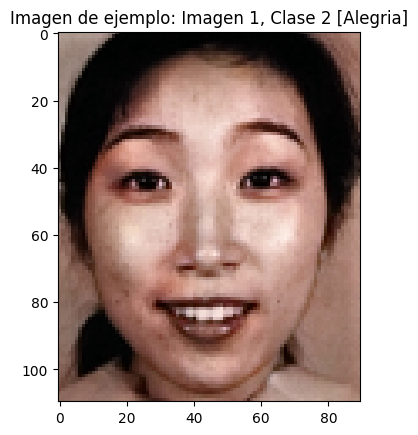

In [34]:
test_img = imageload(2,1)
plt.title('Imagen de ejemplo: Imagen 1, Clase 2 [Alegria]')
plt.imshow(test_img)
plt.show()